In [ ]:
import numpy as np
import pandas as pd #
import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d adityajn105/flickr8k


Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0
 97% 1.00G/1.04G [00:09<00:00, 117MB/s]
100% 1.04G/1.04G [00:10<00:00, 111MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile("flickr8k.zip", "r") as z:
    z.extractall("flickr8k/")


In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import plotly.graph_objects as go
import re
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, add
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import corpus_bleu
from PIL import Image
from tqdm import tqdm_notebook
from collections import Counter

In [ ]:

images_directory = '/content/flickr8k/Images'
# Path to the captions
captions_path = '/content/flickr8k/captions.txt'

In [ ]:
def load_captions(file_path):
    with open(file_path, 'r') as f:
        captions = f.readlines()
        # Lowercasing  the captions
        captions = [caption.lower() for caption in captions[1:]]
    return captions

def tokenize_captions(captions):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(captions)
    return tokenizer

# Loading the captions from the dataset
captions = load_captions(captions_path)
captions[:16:4]

['1000268201_693b08cb0e.jpg,a child in a pink dress is climbing up a set of stairs in an entry way .\n',
 '1000268201_693b08cb0e.jpg,a little girl in a pink dress going into a wooden cabin .\n',
 '1001773457_577c3a7d70.jpg,two dogs of different breeds looking at each other on the road .\n',
 '1002674143_1b742ab4b8.jpg,a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .\n']

In [ ]:
def clean_text(text):
    # Removing punctuation marks
    text = re.sub(r'[^\w\s]', '', text)

    # Removing numbers
    text = re.sub(r'\d+', '', text)

    # Removing extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

cleaned_captions = [clean_text(caption.split(',')[1]) for caption in captions]
cleaned_captions[:15:2]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a little girl climbing into a wooden playhouse',
 'a little girl in a pink dress going into a wooden cabin',
 'a black dog and a tricolored dog playing with each other on the road',
 'two dogs of different breeds looking at each other on the road',
 'a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl',
 'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it',
 'young girl with pigtails painting outside in the grass']

In [ ]:
# Image ID + \t + Caption
captions_IDs = []
for i in range(len(cleaned_captions)):
    #  Adding 'start' word and 'end' word to the captions
    item = captions[i].split(',')[0]+'\t'+'start '+cleaned_captions[i]+' end\n'
    captions_IDs.append(item)

captions_IDs[:20:3], len(captions_IDs)

(['1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
  '1000268201_693b08cb0e.jpg\tstart a little girl climbing the stairs to her playhouse end\n',
  '1001773457_577c3a7d70.jpg\tstart a black dog and a tricolored dog playing with each other on the road end\n',
  '1001773457_577c3a7d70.jpg\tstart two dogs on pavement moving toward each other end\n',
  '1002674143_1b742ab4b8.jpg\tstart a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it end\n',
  '1003163366_44323f5815.jpg\tstart a man lays on a bench while his dog sits by him end\n',
  '1003163366_44323f5815.jpg\tstart a shirtless man lies on a park bench with his dog end\n'],
 40455)

In [ ]:
def visualization(data, num_of_images):
    captions_dictionary = {}

    for item in data[100:100 + (num_of_images * 5)]:
        image_id, caption = item.split('\t')
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)

    list_captions = list(captions_dictionary.items())
    fig = plt.figure(figsize=(10, 20))

    for idx, (filename, captions) in enumerate(list_captions[:num_of_images]):
        image_path = os.path.join(images_directory, filename)
        image_load = load_img(image_path, target_size=(199, 199))

        ax = fig.add_subplot(num_of_images, 2, 2 * idx + 1, xticks=[], yticks=[])
        ax.imshow(image_load)

        ax = fig.add_subplot(num_of_images, 2, 2 * idx + 2)
        plt.axis('off')
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        for i, caption in enumerate(captions):
            ax.text(0, i, caption.strip(), fontsize=10)

    plt.subplots_adjust(hspace=1.5)
    plt.show()


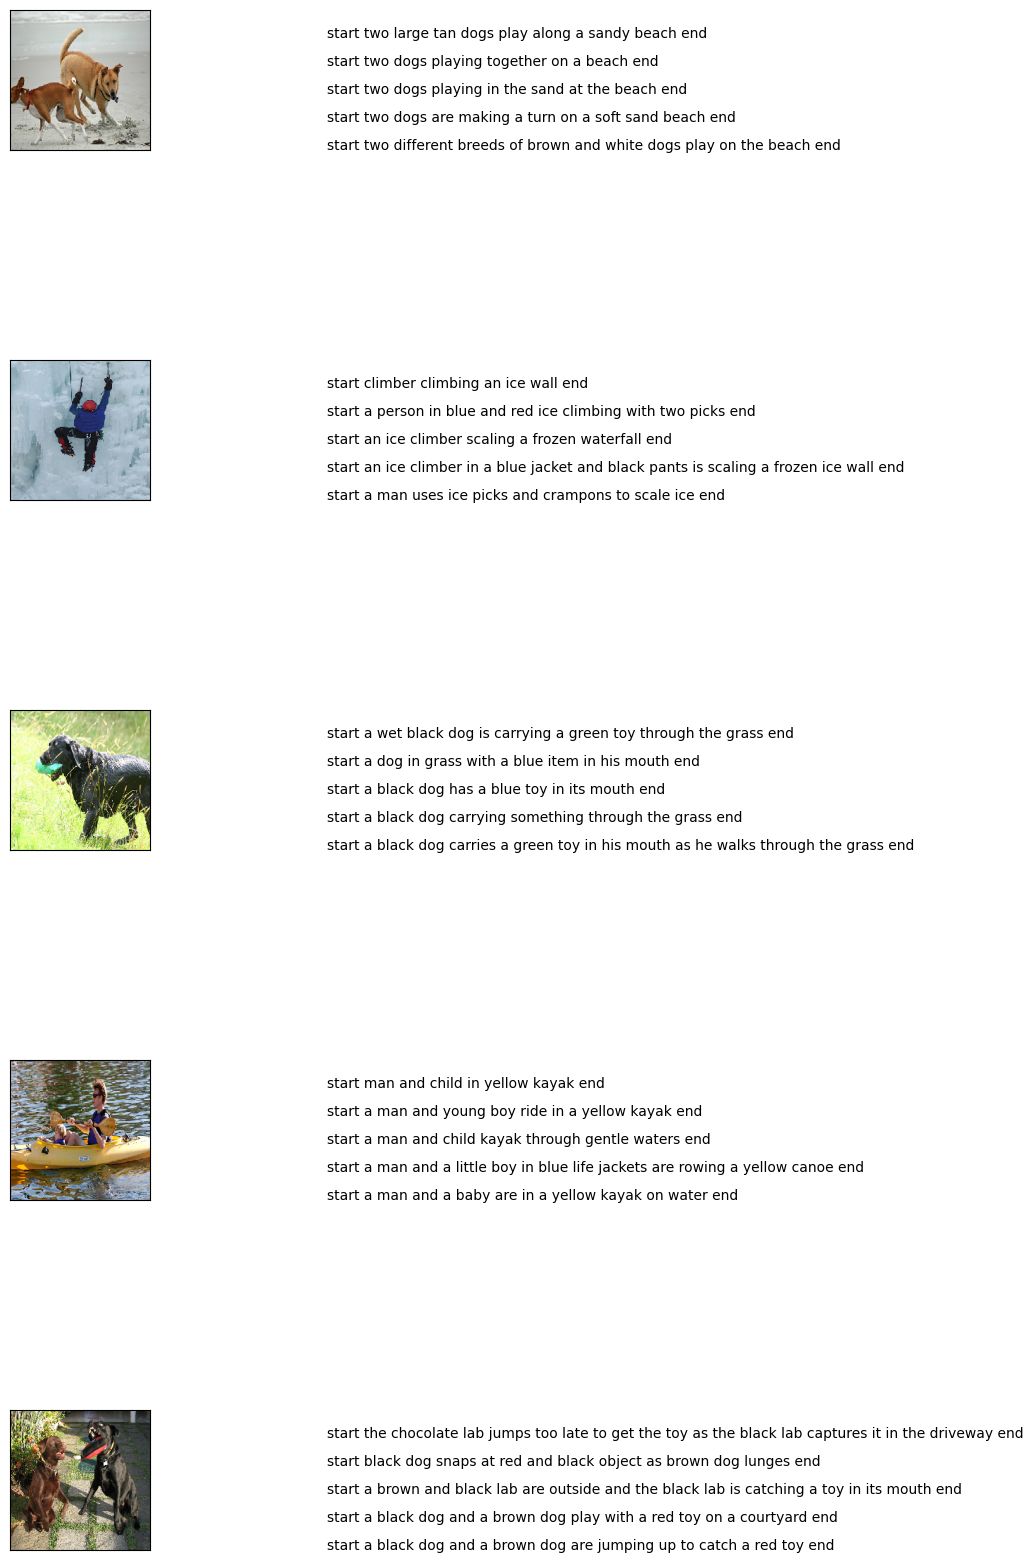

In [ ]:
visualization(captions_IDs,5)


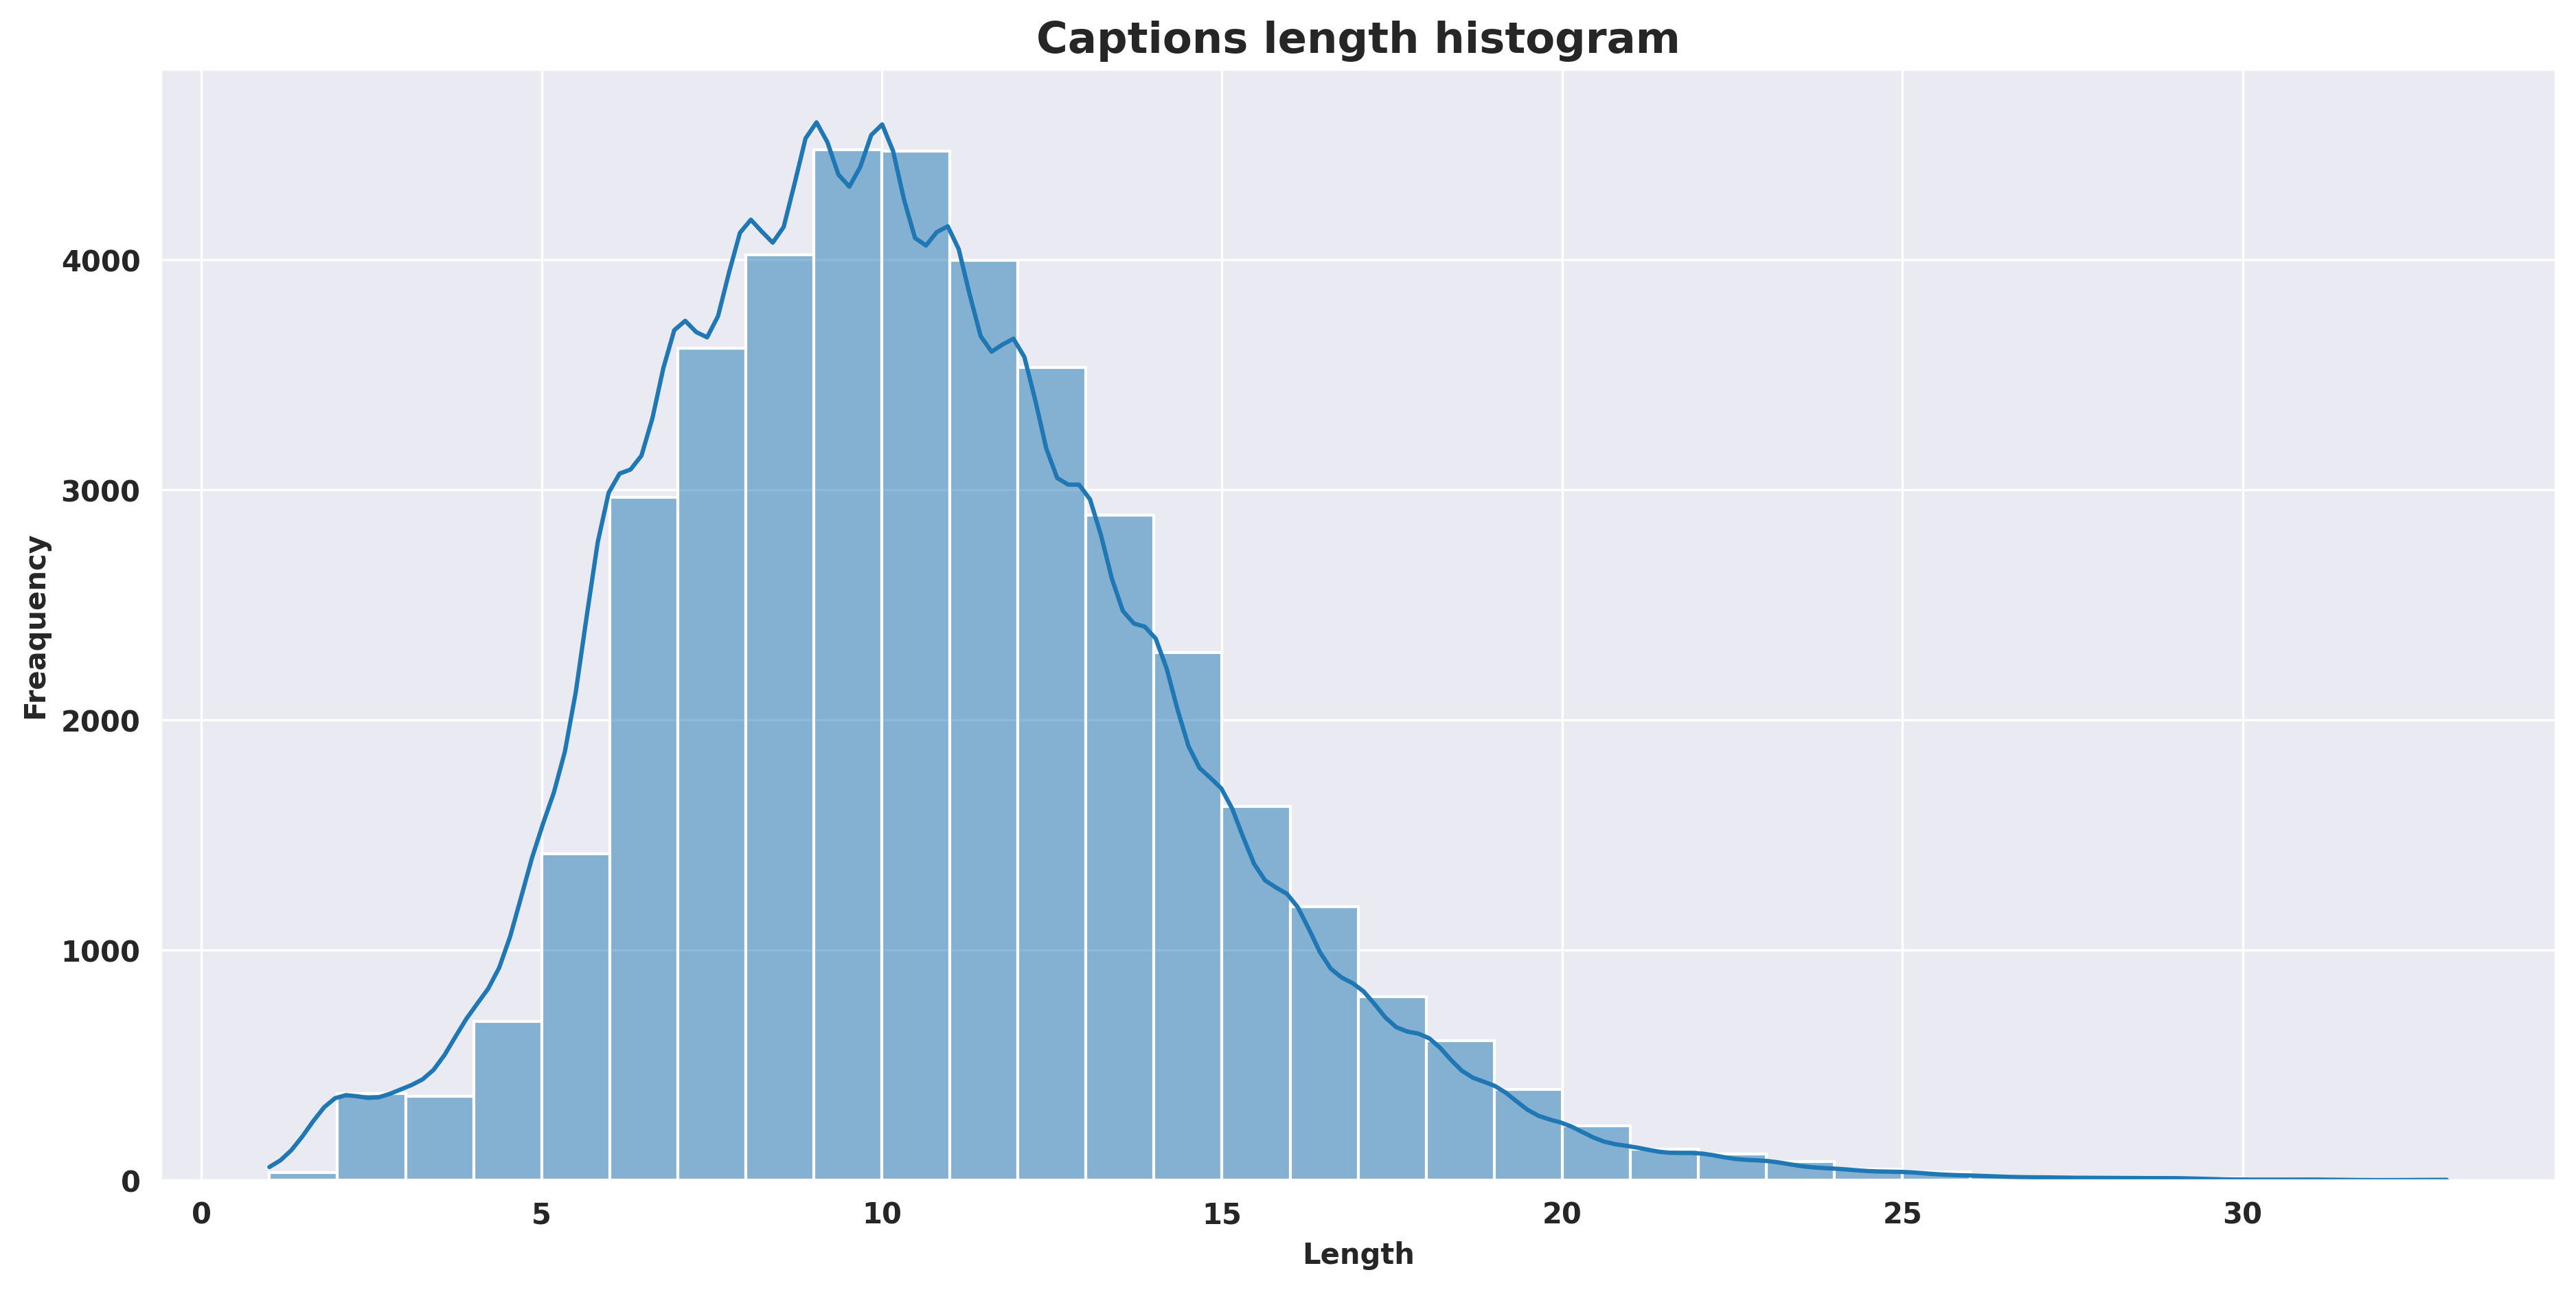

In [30]:
def captions_length(data):
    plt.figure(figsize=(15, 7), dpi=300)
    sns.set_style('darkgrid')
    sns.histplot(x=[len(x.split(' ')) for x in data], kde=True, binwidth=1)
    plt.title('Captions length histogram', fontsize=15, fontweight='bold')
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.xlabel('Length', fontweight='bold')
    plt.ylabel('Freaquency', fontweight='bold')
    plt.show()

captions_length(cleaned_captions)


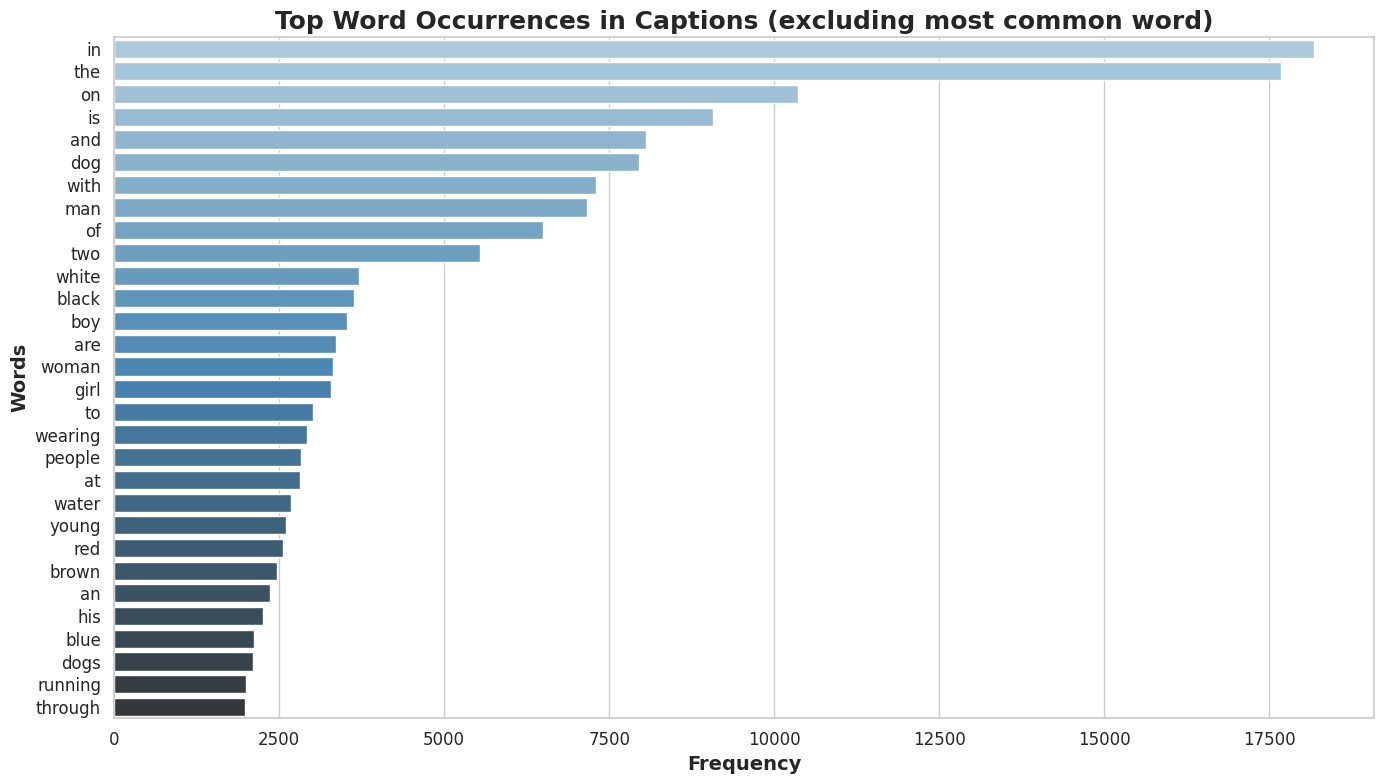

In [41]:
def word_occurrences_barplot(data, top_n=30):
    # Combine all captions into a single string
    all_text = ' '.join(data)

    # Count word frequencies
    word_counts = Counter(all_text.split())

    # Get top N most common words, skipping the first (usually 'a' or 'start')
    common_words = word_counts.most_common(top_n + 1)[1:]  # Skip the first word

    words, values = zip(*common_words)

    # Set Seaborn style
    sns.set(style='whitegrid')

    # Plot
    plt.figure(figsize=(14, 8))
    ax = sns.barplot(x=list(values), y=list(words), palette='Blues_d')
    ax.set_title('Top Word Occurrences in Captions (excluding most common word)', fontsize=18, fontweight='bold')
    ax.set_xlabel('Frequency', fontsize=14, fontweight='bold')
    ax.set_ylabel('Words', fontsize=14, fontweight='bold')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the function
word_occurrences_barplot(cleaned_captions)


In [32]:

tokenizer = tokenize_captions(cleaned_captions)
vocab_size = len(tokenizer.word_index) + 1
vocab_size

8586

In [33]:
# Storing all image IDs
all_image_ids = os.listdir(images_directory)

# Splitting image IDs
train_image_ids, val_image_ids = train_test_split(all_image_ids, test_size=0.15, random_state=42)
val_image_ids, test_image_ids = train_test_split(val_image_ids, test_size=0.1, random_state=42)

train_captions, val_captions, test_captions = [], [], []
for caption in captions_IDs:
    image_id, _ = caption.split('\t')

    if image_id in train_image_ids:
        train_captions.append(caption)

    elif image_id in val_image_ids:
        val_captions.append(caption)

    elif image_id in test_image_ids:
        test_captions.append(caption)

    else:
        print('Unknown image ID !')

train_captions[0], val_captions[0], test_captions[0], len(train_captions)/5, len(val_captions)/5, len(test_captions)/5

('1001773457_577c3a7d70.jpg\tstart a black dog and a spotted dog are fighting end\n',
 '1000268201_693b08cb0e.jpg\tstart a child in a pink dress is climbing up a set of stairs in an entry way end\n',
 '104136873_5b5d41be75.jpg\tstart people sit on the mountainside and check out the view end\n',
 6877.0,
 1092.0,
 122.0)

In [34]:
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(299, 299))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

def extract_image_features(model, image_path):
    img = preprocess_image(image_path)
    features = model.predict(img, verbose=0)
    return features

# Loading the pre-trained InceptionV3 model
inception_v3_model = InceptionV3(weights = 'imagenet', input_shape=(299, 299, 3))
inception_v3_model.layers.pop()
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=inception_v3_model.layers[-2].output)

96112376/96112376 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [35]:
train_image_features, val_image_features, test_image_features = {}, {}, {}  # A Dictionary to store image features with their corresponding IDs

pbar = tqdm_notebook(total=len(all_image_ids), position=0, leave=True, colour='green')

for caption in all_image_ids:
    image_id = caption.split('\t')[0]
    image_path = os.path.join(images_directory, image_id)
    image_features = extract_image_features(inception_v3_model, image_path) # Extracting features

    if image_id in train_image_ids:
        train_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in val_image_ids:
        val_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    elif image_id in test_image_ids:
        test_image_features[image_id] = image_features.flatten()  # Flattening the features
        pbar.update(1)

    else:
        print('Unknown image ID !')

pbar.close()

  0%|          | 0/8091 [00:00<?, ?it/s]

In [60]:
def data_generator(captions, image_features, tokenizer, max_caption_length, batch_size, vocab_size):
    num_samples = len(captions)
    image_ids = list(image_features.keys())
    while True:
        np.random.shuffle(image_ids)
        for start_idx in range(0, num_samples, batch_size):
            end_idx = min(start_idx + batch_size, num_samples)
            X_images, X_captions, y = [], [], []
            for caption in captions[start_idx:end_idx]:
                image_id, caption_text = caption.split('\t')
                caption_text = caption_text.rstrip('\n')
                seq = tokenizer.texts_to_sequences([caption_text])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_caption_length, padding='post')[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    X_images.append(image_features[image_id])
                    X_captions.append(in_seq)
                    y.append(out_seq)

            yield (
                (np.array(X_images, dtype=np.float32),
                 np.array(X_captions, dtype=np.int32)),
                np.array(y, dtype=np.float32)
            )
max_caption_length=34
cnn_output_dim=2048 #inception
train_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(train_captions, train_image_features, tokenizer, max_caption_length, batch_size_train, vocab_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

val_dataset = tf.data.Dataset.from_generator(
    lambda: data_generator(val_captions, val_image_features, tokenizer, max_caption_length, batch_size_val, vocab_size),
    output_signature=(
        (
            tf.TensorSpec(shape=(None, cnn_output_dim), dtype=tf.float32),
            tf.TensorSpec(shape=(None, max_caption_length), dtype=tf.int32)
        ),
        tf.TensorSpec(shape=(None, vocab_size), dtype=tf.float32)
    )
)

max_caption_length = max(len(caption.split()) for caption in cleaned_captions) + 1
cnn_output_dim = inception_v3_model.output_shape[1]  # should be 2048
batch_size_train = 270
batch_size_val = 150


In [61]:
# Checking shapes
sample_batch = next(train_data_generator)
print("Training sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)
print('=========================')
sample_batch = next(val_data_generator)
print("Validation sample batch shapes:")
print("X_images:", sample_batch[0][0].shape)
print("X_captions:", sample_batch[0][1].shape)
print("y:", sample_batch[1].shape)

Training sample batch shapes:
X_images: (3073, 2048)
X_captions: (3073, 34)
y: (3073, 8586)
Validation sample batch shapes:
X_images: (1737, 2048)
X_captions: (1737, 34)
y: (1737, 8586)


In [81]:
def build_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder Model
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1) # Adding a Dense layer to the CNN output to match the decoder output size
    fe3 = BatchNormalization()(fe2)

    # Decoder Model
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256)(se1)


    # Output
    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    # Returning The Model
    model = Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning')
    return model


caption_model = build_model(vocab_size, max_caption_length, cnn_output_dim)

optimizer = Adam(learning_rate=0.01, clipnorm=1.0)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer)

caption_model.summary()

Model: "Image_Captioning"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Features_Input      │ (None, 2048)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ Features_Input[0… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Sequence_Input      │ (None, 34)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    524,544 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_7         │ (None, 34, 256)   │  2,198,016 │ Sequence_Input[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_7         │ (None, 34)        │          0 │ Sequence_Input[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 256)       │    525,312 │ embedding_7[0][0… │
│                     │                   │            │ not_equal_7[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 256)       │          0 │ batch_normalizat… │
│                     │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │     65,792 │ add_7[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Layer        │ (None, 8586)      │  2,206,602 │ dense_15[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,529,482 (21.09 MB)

 Trainable params: 5,524,874 (21.08 MB)

 Non-trainable params: 4,608 (18.00 KB)

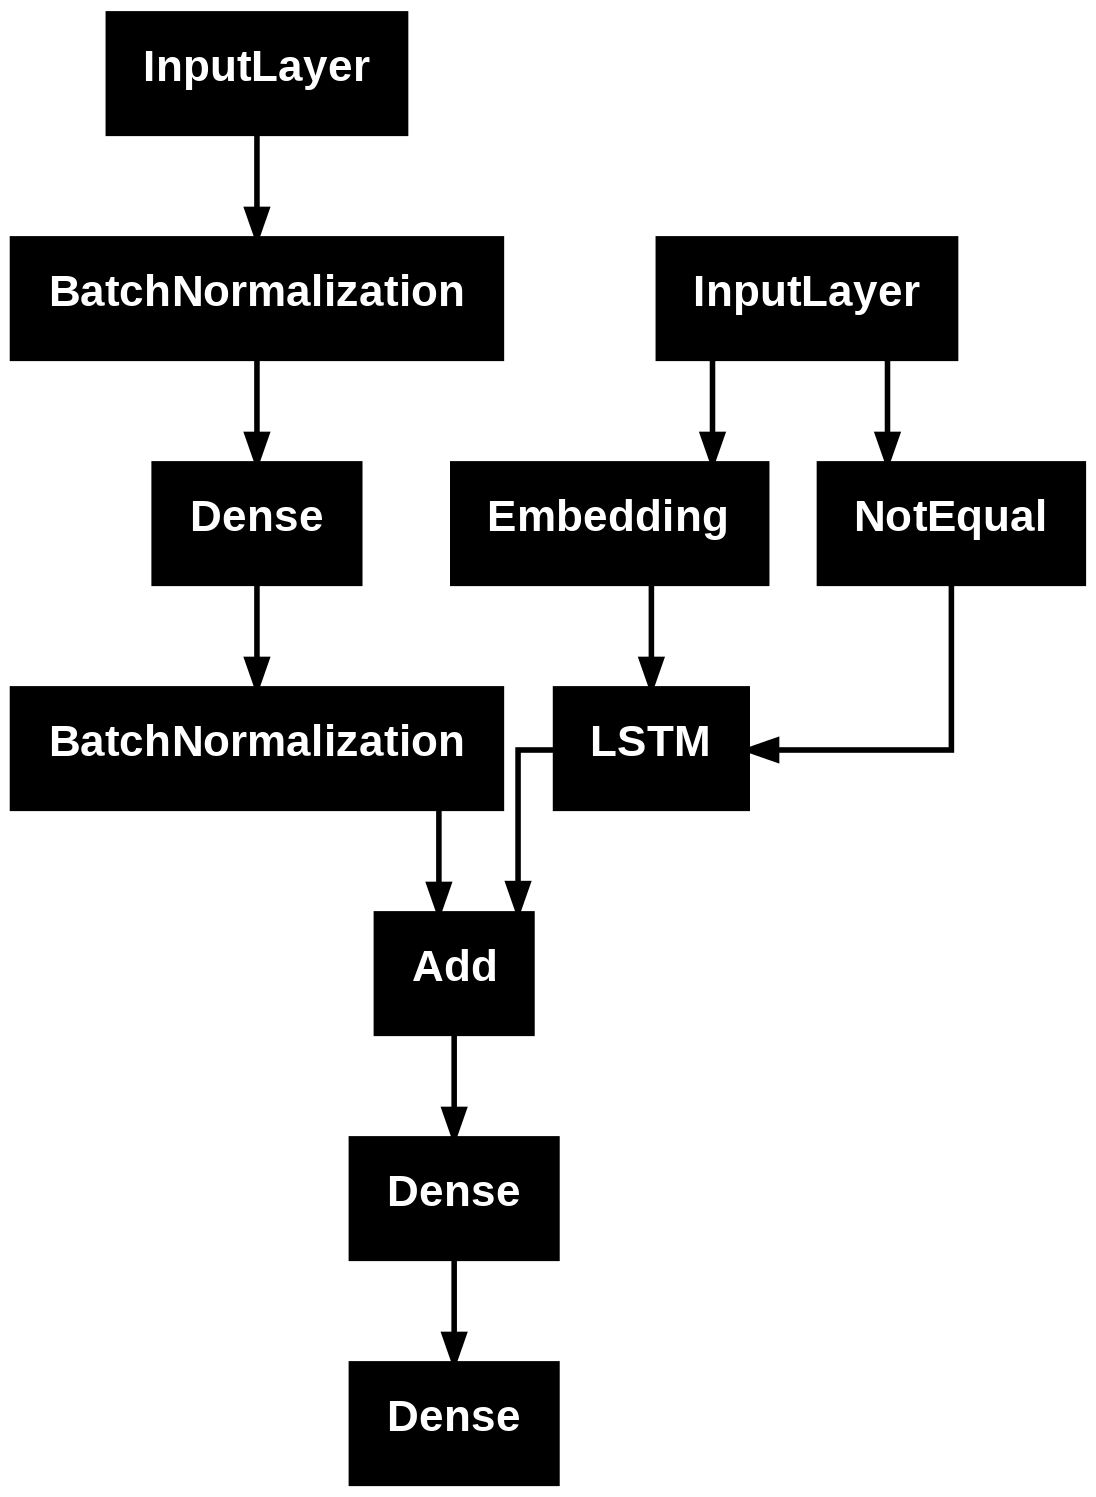

In [82]:
plot_model(caption_model)

In [83]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


def lr_scheduler(epoch, lr):
    return float(lr * np.exp(-0.6))

lr_schedule = LearningRateScheduler(lr_scheduler)

# Now fit the model
history = caption_model.fit(
    train_dataset,
    steps_per_epoch=len(train_captions) // batch_size_train,
    validation_data=val_dataset,
    validation_steps=len(val_captions) // batch_size_val,
    epochs=15,
    callbacks=[early_stopping, lr_schedule]
)


Epoch 1/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 58s 430ms/step - loss: 5.1801 - val_loss: 3.6910 - learning_rate: 0.0055
Epoch 2/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 55s 439ms/step - loss: 3.3437 - val_loss: 3.3373 - learning_rate: 0.0030
Epoch 3/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 58s 456ms/step - loss: 2.9426 - val_loss: 3.2307 - learning_rate: 0.0017
Epoch 4/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 59s 468ms/step - loss: 2.7208 - val_loss: 3.2058 - learning_rate: 9.0718e-04
Epoch 5/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 58s 457ms/step - loss: 2.5893 - val_loss: 3.2008 - learning_rate: 4.9787e-04
Epoch 6/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 430ms/step - loss: 2.5041 - val_loss: 3.2023 - learning_rate: 2.7324e-04
Epoch 7/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 57s 450ms/step - loss: 2.4548 - val_loss: 3.2080 - learning_rate: 1.4996e-04
Epoch 8/15
127/127 ━━━━━━━━━━━━━━━━━━━━ 54s 428ms/step - loss: 2.4261 - val_loss: 3.2125 - learning_rate: 8.2297e-05


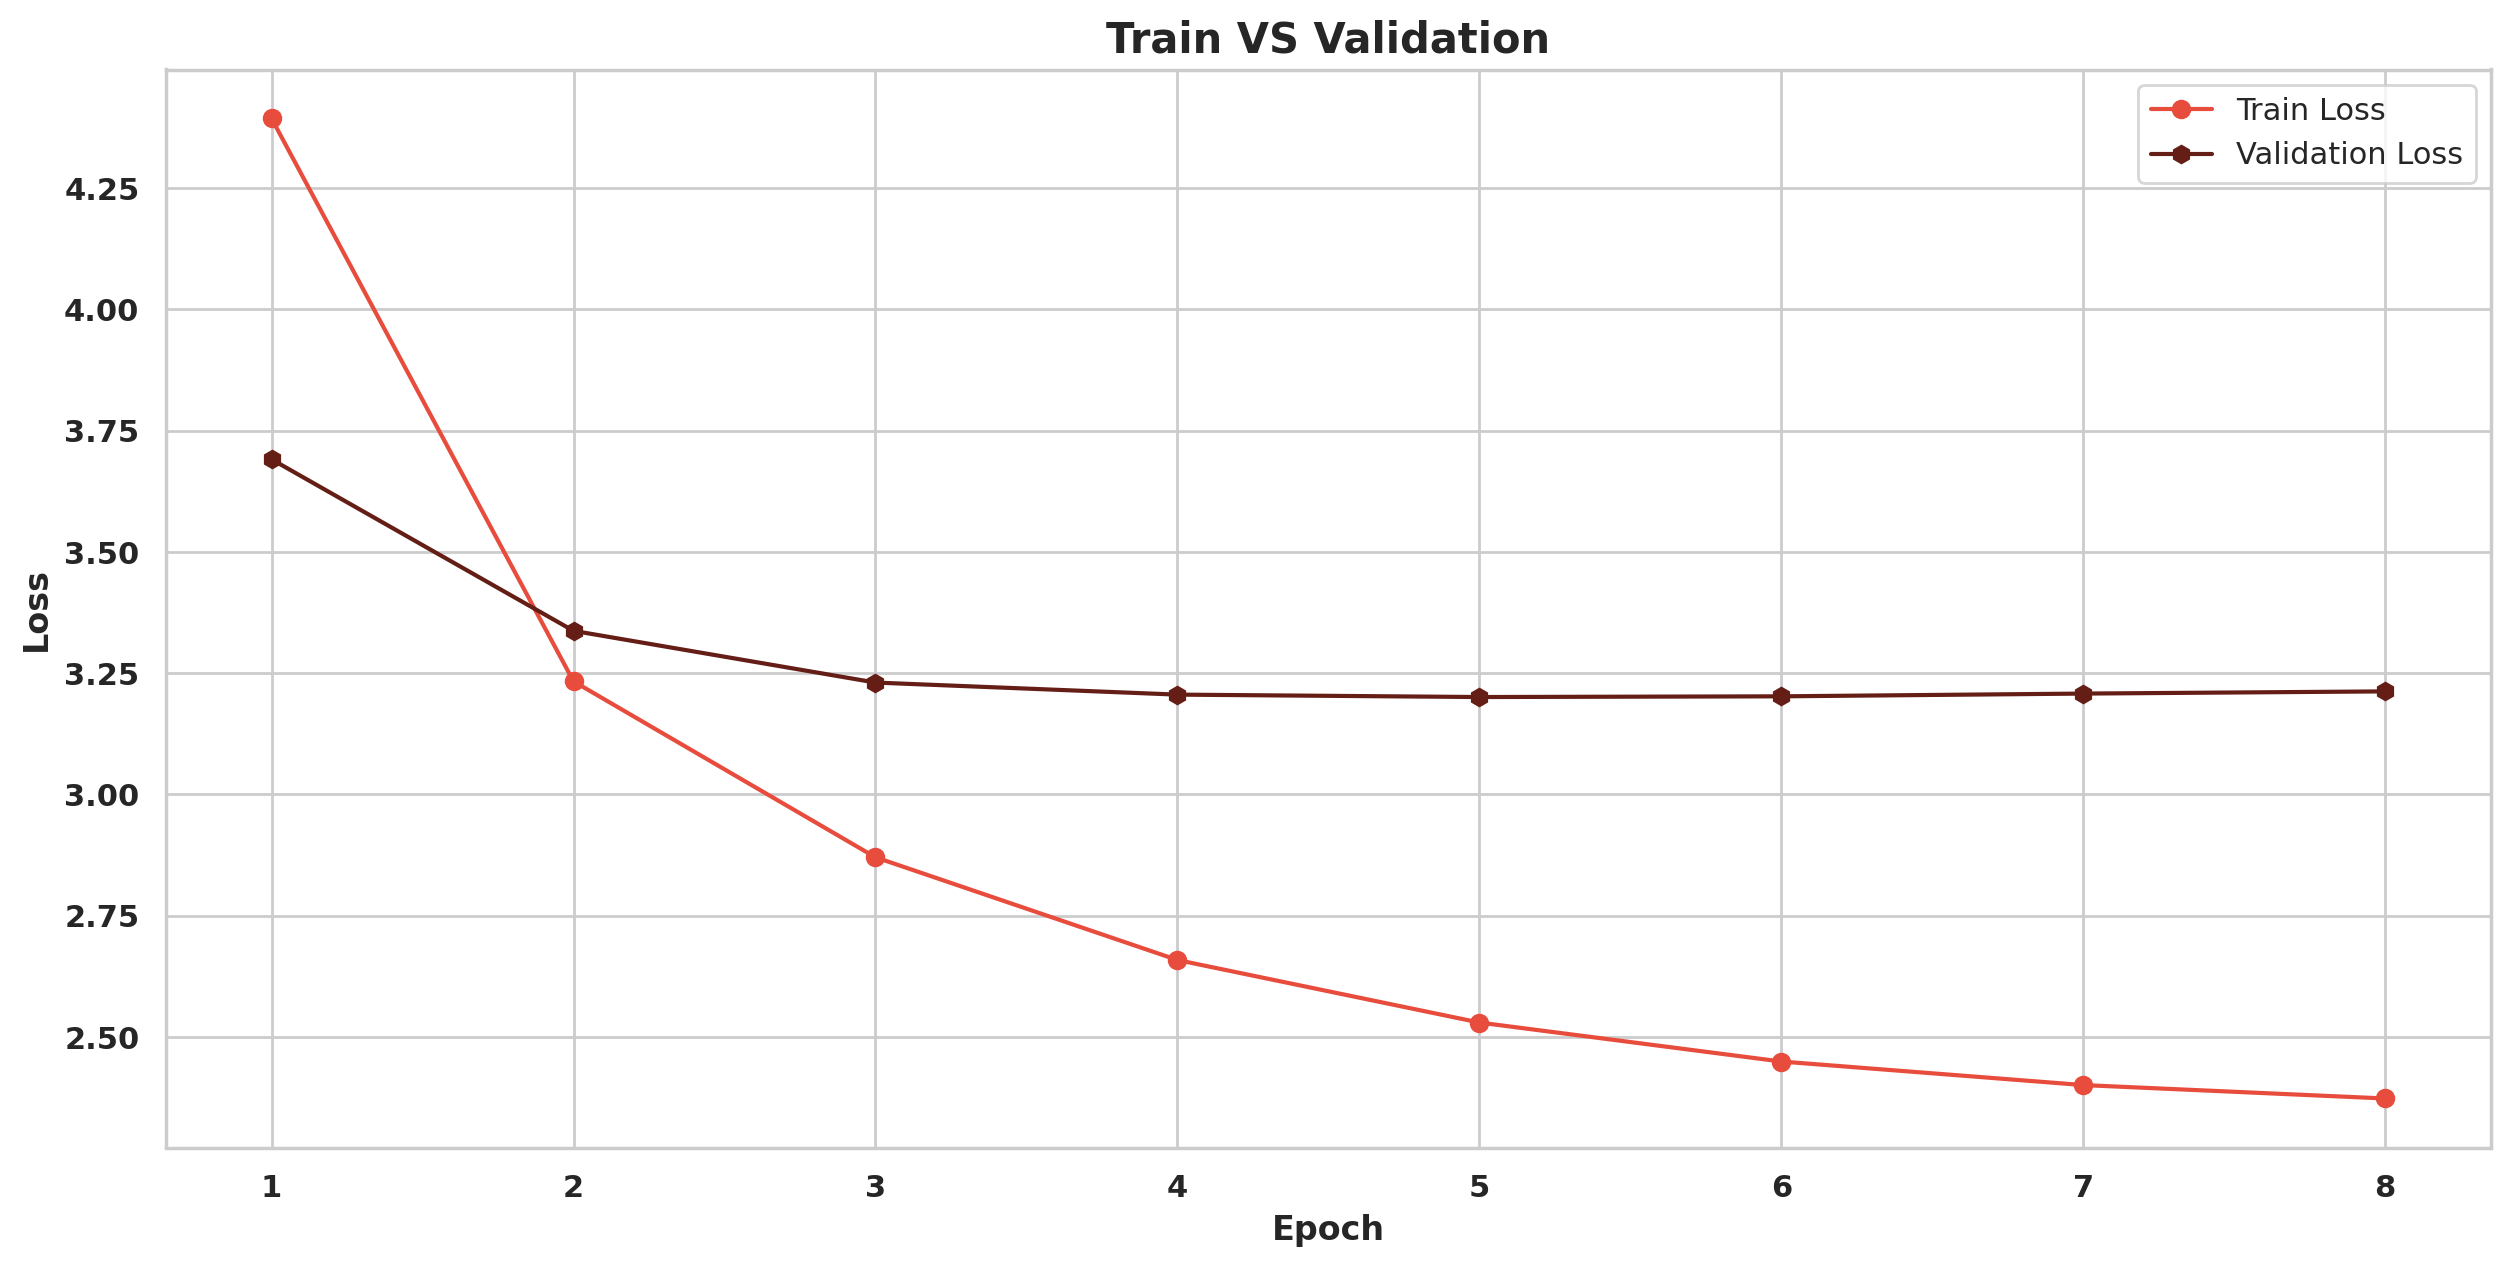

In [84]:
plt.figure(figsize=(15, 7), dpi=200)
sns.set_style('whitegrid')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['loss'], color='#E74C3C', marker='o')
plt.plot([x+1 for x in range(len(history.history['loss']))], history.history['val_loss'], color='#641E16', marker='h')
plt.title('Train VS Validation', fontsize=15, fontweight='bold')
plt.xticks(fontweight='bold')
plt.yticks(fontweight='bold')
plt.xlabel('Epoch', fontweight='bold')
plt.ylabel('Loss', fontweight='bold')
plt.legend(['Train Loss', 'Validation Loss'], loc='best')
plt.show()

In [86]:
caption_model.save_weights("caption_model.weights.h5")




In [87]:
def build_inference_model(vocab_size, max_caption_length, cnn_output_dim):
    # Encoder
    input_image = Input(shape=(cnn_output_dim,), name='Features_Input')
    fe1 = BatchNormalization()(input_image)
    fe2 = Dense(256, activation='relu')(fe1)
    fe3 = BatchNormalization()(fe2)

    # Decoder with safer LSTM for inference
    input_caption = Input(shape=(max_caption_length,), name='Sequence_Input')
    se1 = Embedding(vocab_size, 256, mask_zero=True)(input_caption)
    se2 = LSTM(256, return_sequences=False, recurrent_activation='sigmoid', unroll=True)(se1)

    decoder1 = add([fe3, se2])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax', name='Output_Layer')(decoder2)

    return Model(inputs=[input_image, input_caption], outputs=outputs, name='Image_Captioning_Inference')
caption_model_infer = build_inference_model(vocab_size, max_caption_length, cnn_output_dim)
caption_model_infer.load_weights('caption_model.weights.h5')


In [88]:
def greedy_generator_infer(image_features):
    in_text = 'start'
    for _ in range(max_caption_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_caption_length)
        prediction = caption_model_infer.predict([image_features.reshape(1, cnn_output_dim), sequence], verbose=0)
        predicted_id = np.argmax(prediction)
        word = tokenizer.index_word.get(predicted_id, '')
        if word == 'end' or word == '':
            break
        in_text += ' ' + word

    return in_text.replace('start ', '')


In [ ]:
# A dictionary to access actual captions of each image by its ID
test_actual_captions = {}
for item in test_captions:
    image_id, caption = item.split('\t')
    if image_id not in test_actual_captions:
        test_actual_captions[image_id] = []
    test_actual_captions[image_id].append(caption)

In [89]:
# Example usage
image_id = list(test_image_features.keys())[0]
image_feat = test_image_features[image_id]
generated_caption = greedy_generator_infer(image_feat)
print("Generated Caption:", generated_caption)


Generated Caption: a dog is running in the snow


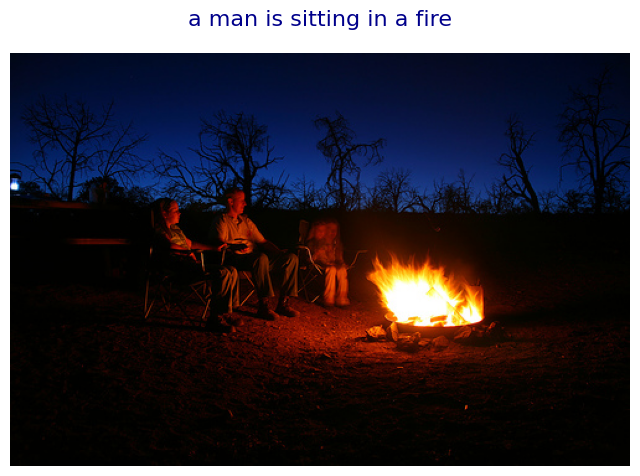

In [94]:
import matplotlib.image as mpimg
def show_image_with_caption(image_id, image_features_dict, image_dir, model, tokenizer):
    # Generate the caption
    image_features = image_features_dict[image_id]
    caption = greedy_generator_infer(image_features)

    # Load image from disk
    image_path = os.path.join(image_dir, image_id)
    img = mpimg.imread(image_path)

    # Plot the image
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='darkblue', pad=20)
    plt.show()

# Example usage:
# Replace with your test image ID and directory path
test_image_id = list(test_image_features.keys())[2]
show_image_with_caption(test_image_id, test_image_features, images_directory, caption_model_infer, tokenizer)

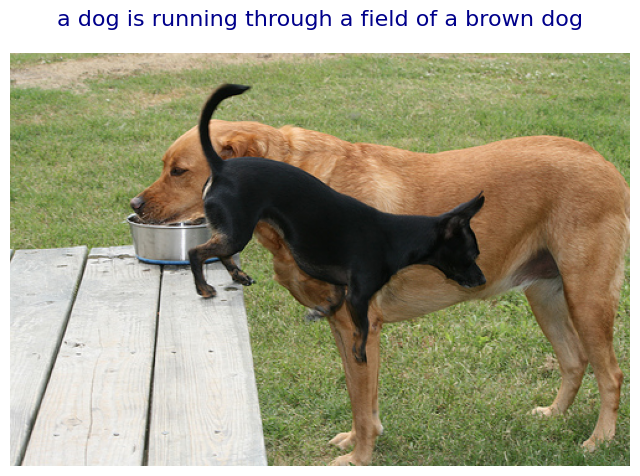

In [95]:

# Replace with your test image ID and directory path
test_image_id = list(test_image_features.keys())[3]
show_image_with_caption(test_image_id, test_image_features, images_directory, caption_model_infer, tokenizer)

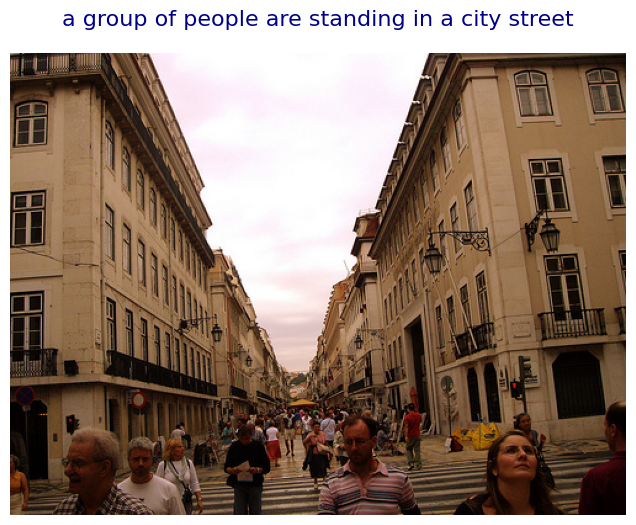

In [97]:

# Replace with your test image ID and directory path
test_image_id = list(test_image_features.keys())[5]
show_image_with_caption(test_image_id, test_image_features, images_directory, caption_model_infer, tokenizer)

In [98]:
generated_captions = {}
print("Generating captions...")
for image_id in tqdm(test_image_features):
    caption = greedy_generator_infer(test_image_features[image_id])
    generated_captions[image_id] = caption

# Step 2: Prepare actual reference captions (tokenized)
actual_captions = []
predicted_captions = []

for image_id in generated_captions:
    # Tokenized list of ground truth captions
    actual = [caption.strip().split() for caption in test_actual_captions[image_id]]

    # Tokenized generated caption
    predicted = generated_captions[image_id].strip().split()

    actual_captions.append(actual)
    predicted_captions.append(predicted)

# Step 3: Calculate BLEU scores
bleu_1 = corpus_bleu(actual_captions, predicted_captions, weights=(1.0, 0, 0, 0))
bleu_2 = corpus_bleu(actual_captions, predicted_captions, weights=(0.5, 0.5, 0, 0))

print("\n--- BLEU Scores (Greedy) ---")
print(f"BLEU-1: {round(bleu_1, 4)}")
print(f"BLEU-2: {round(bleu_2, 4)}")

Generating captions...


  0%|          | 0/122 [00:00<?, ?it/s]


--- BLEU Scores (Greedy) ---
BLEU-1: 0.5601
BLEU-2: 0.3765


In [99]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
